In [282]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *


# Get Data 
---

In [283]:
# merge_ohlc_closing_prices('binance_data/top_100_tickers/2024/1m')

 * ## Closing Price Data


In [284]:

#prices = pd.read_csv("binance_data/Staked_ETH_Bybit/merged_closing_prices.csv", index_col=0, parse_dates=True)

#prices = pd.read_csv("binance_data/From_Paper/2023/1m/merged_From_Paper_closing_prices_OCT_NOV.csv", index_col=0, parse_dates=True)

#BTC and WBTC
#-------------------------------------------
#prices = pd.read_csv("binance_data/Wrapped BTC/2024/30m/merged_closing_prices.csv", index_col=0, parse_dates=True)

#prices = pd.read_csv("binance_data/Wrapped BTC/2024/1m/merged_closing_prices.csv", index_col=0, parse_dates=True)


#SOL and BNSOL
#-------------------------------------------
#prices = pd.read_csv('binance_data/SOL_and_BNSOL/2025/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

#ETH and WBTC
#-------------------------------------------
#prices = pd.read_csv('binance_data/ETH_and_WBETH/2024/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

#Top 100
#-------------------------------------------
prices = pd.read_csv('binance_data/top_100_tickers/2024/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

In [285]:
#prices = prices[['XRP/USDT_2024_1m', 'ADA/USDT_2024_1m']]

#prices = prices[['ADA/USDT_2024_1m','XRP/USDT_2024_1m']]


#prices = prices[['DOT/USDT_2024_1m', 'XTZ/USDT_2024_1m']]

#BCH/USDT_2024_1m & DOGE/USDT_2024_1m
#-------------------------------------------
#prices = prices[['BCH/USDT_2024_1m', 'DOGE/USDT_2024_1m']]

#GALA/USDT_2024_1m & GRT/USDT_2024_1m,0.0056584346126191745,-4.071777010162084
#-------------------------------------------
#prices = prices[['GALA/USDT_2024_1m', 'GRT/USDT_2024_1m']]

prices = prices[['GRT/USDT_2024_1m', 'GALA/USDT_2024_1m']]

In [286]:
#Filter prices to only include first 6 months of 2024
prices = prices.loc['2024-01-01':'2024-06-30']

In [287]:
# count_unchanged_rows = (prices.diff().eq(0).all(axis=1)).sum()
# print("Number of fully unchanged rows:", count_unchanged_rows)

In [288]:
# prices = prices[prices.diff().ne(0).all(axis=1)]

In [289]:
# count_unchanged_rows = (prices.diff().eq(0).all(axis=1)).sum()
# print("Number of fully unchanged rows:", count_unchanged_rows)

In [290]:
prices

,GRT/USDT_2024_1m,GALA/USDT_2024_1m
timestamp,,
2024-01-01 00:00:00,0.1847,0.03037
2024-01-01 00:01:00,0.1848,0.03042
2024-01-01 00:02:00,0.1850,0.03049
2024-01-01 00:03:00,0.1854,0.03050
2024-01-01 00:04:00,0.1856,0.03058
...,...,...
2024-06-30 23:55:00,0.2108,0.02770
2024-06-30 23:56:00,0.2107,0.02768
2024-06-30 23:57:00,0.2107,0.02770


 * ## Order book data


In [291]:
# #BTC and WBTC
# #-------------------------------------------
#prices = pd.read_csv('order_book_data/merged_data/1min/btc_wbtc_combined_1m.csv', index_col=0, parse_dates=True)

#ETH and WBETH
#prices = pd.read_csv('order_book_data/merged_data/1min/eth_wbeth_combined_1m.csv', index_col=0, parse_dates=True)


In [292]:
# Only show mid prices
#prices = prices[['btc_mid_price', 'wbtc_mid_price']]

#prices = prices[['eth_mid_price','wbeth_mid_price']]

In [293]:
# #Fliter prices to end in May
# prices = prices.loc['2024-01-01':'2024-05-31']

In [294]:
# prices_ETH = pd.read_csv('binance_data/ETH_and_WBETH/2024/1m/ETHUSDT_2024_1m.csv', index_col=0, parse_dates=True)
# prices_WBETH = pd.read_csv('binance_data/ETH_and_WBETH/2024/1m/WBETHUSDT_2024_1m.csv', index_col=0, parse_dates=True)   
# prices_WBTC = pd.read_csv('binance_data/Wrapped BTC/2024/1m/WBTCUSDT_2024_1m.csv', index_col=0, parse_dates=True)
# prices_BTC = pd.read_csv('binance_data/Wrapped BTC/2024/1m/BTCUSDT_2024_1m.csv', index_col=0, parse_dates=True)

In [295]:
#get prices for dates greater than or equal to 2024-01-01 16:30:00	

#prices = prices.loc[prices.index >= "2024-01-01 16:30:00"]

# Trading simulation
---

* ## In-Sample Testing

In [296]:
# #XVS/USDT_2024_30m & QI/USDT_2024_30m


# crypto_1 = prices.columns[0]
# crypto_2 = prices.columns[1]

# cointegrated_pairs = [(crypto_1,
#   crypto_2,
#   0.731393,
#   0.8501886494196308,
#   0.22)]

In [297]:
#Params:
window_size = 1440
entry_threshold= 3 #3 was prev
exit_threshold= 0
stop_loss_threshold = 100

In [298]:
prices.columns

Index(['GRT/USDT_2024_1m', 'GALA/USDT_2024_1m'], dtype='object')

## For Closing Price Data 
---

In [299]:
sym1, sym2 = prices.columns
print(f"\nTesting strategy on pair: {sym1} and {sym2} ...")
S1 = prices[sym1]
S2 = prices[sym2]

# Compute the spread series and beta_series 
spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

#                                   FOR CLOSING PRICE DATA
#------------------------------------------------------------------------------------------
# Generate trading signals (positions) based on the spread's z-score
positions, trade_entries, trade_exits = backtest_pair_rolling(spread_series,S1,S2,zscore_series, entry_threshold, exit_threshold, stop_loss_threshold)




Testing strategy on pair: GRT/USDT_2024_1m and GALA/USDT_2024_1m ...
Total trades closed: 143 (Wins=143, Losses=0)
Win rate: 1.00


In [300]:
S1

timestamp
2024-01-01 00:00:00    0.1847
2024-01-01 00:01:00    0.1848
2024-01-01 00:02:00    0.1850
2024-01-01 00:03:00    0.1854
2024-01-01 00:04:00    0.1856
                        ...  
2024-06-30 23:55:00    0.2108
2024-06-30 23:56:00    0.2107
2024-06-30 23:57:00    0.2107
2024-06-30 23:58:00    0.2106
2024-06-30 23:59:00    0.2106
Name: GRT/USDT_2024_1m, Length: 262080, dtype: float64

## For Order Book Data 
---

In [301]:
prices.columns

Index(['GRT/USDT_2024_1m', 'GALA/USDT_2024_1m'], dtype='object')

In [302]:
# sym1, S1_ask_price, S1_bid_price,S1_ask_amount,S1_bid_amount,sym2,S2_ask_price, S2_bid_price,S2_ask_amount,S2_bid_amount  = prices.columns
# print(f"\nTesting strategy on pair: {sym1} and {sym2} ...")

# #Gather relevant columns from order book data
# #-------------------------------------------
# S1_mid_price = prices[sym1]
# S2_mid_price = prices[sym2]
# #-------------------------------------------
# S1_ask_price = prices[S1_ask_price]
# S1_ask_amount = prices[S1_ask_amount]
# S1_bid_price = prices[S1_bid_price]
# S1_bid_amount = prices[S1_bid_amount]
# #-------------------------------------------
# S2_ask_price = prices[S2_ask_price]
# S2_ask_amount = prices[S2_ask_amount]
# S2_bid_price = prices[S2_bid_price]
# S2_bid_amount = prices[S2_bid_amount]
# #-------------------------------------------

# # Compute the spread series and beta_series 
# spread_series, beta_series, alpha_series = compute_spread_series(S1_mid_price, S2_mid_price, window_size)
# #print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# # Compute rolling z-score using the provided helper function.
# zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

# #                                   FOR CLOSING PRICE DATA
# #------------------------------------------------------------------------------------------
# # Generate trading signals (positions) based on the spread's z-score
# #positions, trade_entries, trade_exits = backtest_pair_rolling(spread_series,S1,S2,zscore_series, entry_threshold, exit_threshold, stop_loss_threshold)

# #                                   FOR ORDER BOOK DATA
# #------------------------------------------------------------------------------------------
# positions, trade_entries, trade_exits = backtest_pair_rolling_order_book(spread_series,
#                                                                          S1_mid_price,
#                                                                          S2_mid_price,
#                                                                          S1_ask_price,
#                                                                          S1_ask_amount,
#                                                                          S1_bid_price,
#                                                                          S1_bid_amount,
#                                                                          S2_ask_price,
#                                                                          S2_ask_amount,
#                                                                          S2_bid_price,
#                                                                          S2_bid_amount,
#                                                                          zscore_series, 
#                                                                          entry_threshold, 
#                                                                          exit_threshold, 
#                                                                          stop_loss_threshold)



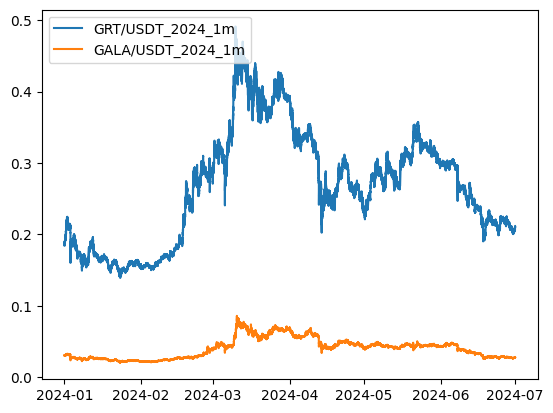

In [303]:
#Plot the closing prices of the merged data using different y axis

crypto_1 = prices.columns[0]
crypto_2 = prices.columns[1]

plt.plot(prices[crypto_1], label=crypto_1)
plt.plot(prices[crypto_2], label=crypto_2)
plt.legend(loc='upper left')
plt.show()






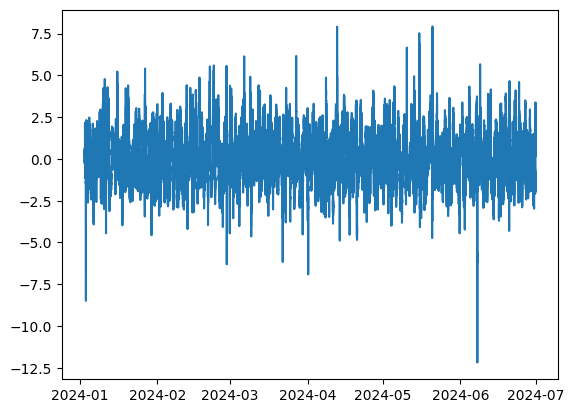

In [304]:
plt.plot(zscore_series)

In [305]:
initial_capital = 10_000.0
#tx_cost= 0.00031 #0.031% transaction cost
tx_cost= 0.00025 #0.025% transaction cost #Binance level 5 Maker Cost

trade_profits, net_trade_profits_S1, net_trade_profits_S2,cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series, tx_cost)

Trade Num: 0
-----------------------------------------------
Trade type: 1, Entry time: 2024-01-03 12:01:00, Exit time: 2024-01-03 12:43:00
Net Trade profit (includes fees): 457.30918288617437
Beta at entry (Not the absolute value): 3.4151906027771153
Notional S1: 2264.9078827333274, Notional S2: 7735.092117266672, Shares S1 : 11777.992109897697, Shares S2: 268114.1115170423
Percentage change S1: -3.74%, Percentage change S2: -7.07%
Trade Num: 1
-----------------------------------------------
Trade type: 1, Entry time: 2024-01-06 14:28:00, Exit time: 2024-01-06 22:17:00
Net Trade profit (includes fees): 14.567509038752942
Beta at entry (Not the absolute value): 10.024138633239147
Notional S1: 907.1003488516335, Notional S2: 9092.899651148367, Shares S1 : 5249.4233151136195, Shares S2: 346924.8245382818
Percentage change S1: -0.52%, Percentage change S2: -0.27%
Trade Num: 2
-----------------------------------------------
Trade type: -1, Entry time: 2024-01-10 07:00:00, Exit time: 2024-0

Maximum Drawdown %: -190.27


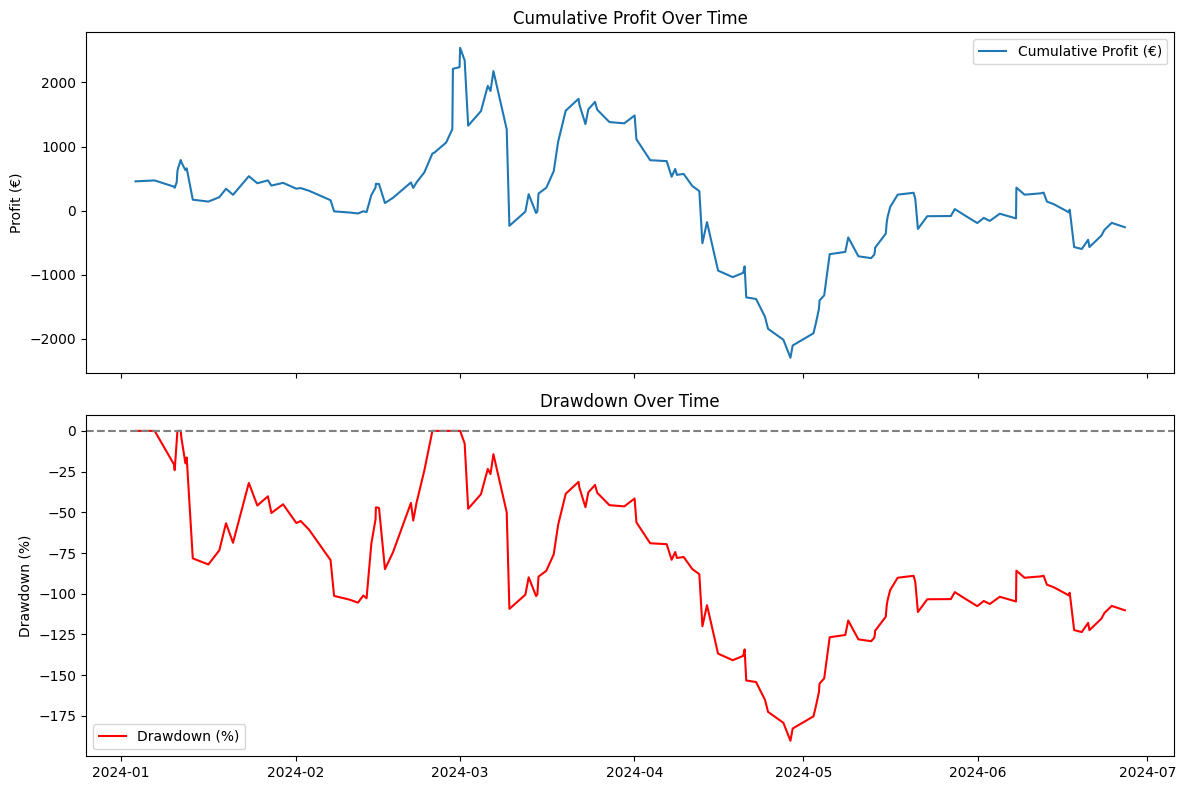

In [306]:

running_max = np.maximum.accumulate(cumulative_profit_series)
# Compute percentage drawdown: negative values indicating how far below running max
drawdown = ((cumulative_profit_series - running_max) / running_max) * 100

# max_drawdown (in %):
max_drawdown = drawdown.min()
print(f"Maximum Drawdown %: {max_drawdown:.2f}")

# ----- PLOT -----
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot cumulative PnL
axes[0].plot(cumulative_profit_series, label='Cumulative Profit (€)')
axes[0].set_title("Cumulative Profit Over Time")
axes[0].set_ylabel("Profit (€)")
axes[0].legend(loc='best')

# Plot drawdown
axes[1].plot(drawdown, color='red', label='Drawdown (%)')
axes[1].set_title("Drawdown Over Time")
axes[1].set_ylabel("Drawdown (%)")
axes[1].axhline(0, color='gray', linestyle='--')  # zero line
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()


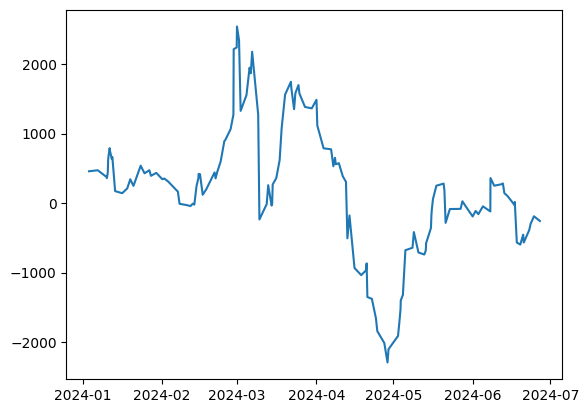

In [307]:
plt.plot(cumulative_profit_series)

In [308]:
exit_times

[Timestamp('2024-01-03 12:43:00'),
 Timestamp('2024-01-06 22:17:00'),
 Timestamp('2024-01-10 08:40:00'),
 Timestamp('2024-01-10 11:34:00'),
 Timestamp('2024-01-10 20:05:00'),
 Timestamp('2024-01-10 23:13:00'),
 Timestamp('2024-01-11 02:09:00'),
 Timestamp('2024-01-11 13:19:00'),
 Timestamp('2024-01-11 16:03:00'),
 Timestamp('2024-01-12 09:16:00'),
 Timestamp('2024-01-12 14:43:00'),
 Timestamp('2024-01-13 16:35:00'),
 Timestamp('2024-01-16 10:57:00'),
 Timestamp('2024-01-18 09:41:00'),
 Timestamp('2024-01-19 13:59:00'),
 Timestamp('2024-01-20 19:48:00'),
 Timestamp('2024-01-23 15:12:00'),
 Timestamp('2024-01-25 03:13:00'),
 Timestamp('2024-01-27 00:22:00'),
 Timestamp('2024-01-27 15:14:00'),
 Timestamp('2024-01-29 16:56:00'),
 Timestamp('2024-02-01 01:19:00'),
 Timestamp('2024-02-01 19:51:00'),
 Timestamp('2024-02-03 07:42:00'),
 Timestamp('2024-02-07 03:00:00'),
 Timestamp('2024-02-07 18:04:00'),
 Timestamp('2024-02-10 10:44:00'),
 Timestamp('2024-02-11 23:56:00'),
 Timestamp('2024-02-

In [309]:
#Measure delta netrality deviation
#-------------------------------------------

#Epsilon = 0.0001 #A small number to avoid division by zero

#Get entry betas for each trade
entry_betas = beta_series[entry_times]

#For each trade, measure the actual ratios as the change in S1 over the change in S2

trade_ranges = [(entry, exit) for entry, exit in zip(entry_times, exit_times)]

#Get the prices of S1 and S2 over the trade range
S1_trade_ranges_prices = [S1[entry:exit] for entry, exit in trade_ranges]
S2_trade_ranges_prices = [S2[entry:exit] for entry, exit in trade_ranges]

#Calculate the change in S1 and S2 over their trade range prices
S1_trade_ranges_changes = [S1_prices.diff()  for S1_prices in S1_trade_ranges_prices]  #Add Epsilon to avoid division by zero when calculating the ratio
S2_trade_ranges_changes = [S2_prices.diff() for S2_prices in S2_trade_ranges_prices] #Add Epsilon to avoid division by zero when calculating the ratio

#Nan check


#Drop nans
S1_trade_ranges_changes = [changes.dropna() for changes in S1_trade_ranges_changes]
S2_trade_ranges_changes = [changes.dropna() for changes in S2_trade_ranges_changes]


# #Remove differences of 0 --> DON'T DO THIS BECAUSE THEN S1 AND S2 WILL HAVE MISMATCHES IN THEIR INDICES, WHICH WILL CASE ISSUES WHEN YOU TRY TAKE RATIOS. DROP NAN AND INF RATIOS INSTEAD
# S1_trade_ranges_changes = [changes[changes != 0] for changes in S1_trade_ranges_changes]
# S2_trade_ranges_changes = [changes[changes != 0] for changes in S2_trade_ranges_changes]

#Count number of 0 values in S1 and S2 changes
count_0_S1 = [np.count_nonzero(changes == 0) for changes in S1_trade_ranges_changes]
count_0_S2 = [np.count_nonzero(changes == 0) for changes in S2_trade_ranges_changes]
# print("Number of 0 values in S1 changes:", count_0_S1)
# print("Number of 0 values in S2 changes:", count_0_S2)

#Check if time series are equal in length for each trade
for i, (S1_changes, S2_changes) in enumerate(zip(S1_trade_ranges_changes, S2_trade_ranges_changes)):
    if len(S1_changes) != len(S2_changes):
        print(f"Trade {i} has different lengths: S1 changes: {len(S1_changes)}, S2 changes: {len(S2_changes)}")

#Nan check
#------------------------------------
for series in S1_trade_ranges_changes:
    if series.isna().sum() > 0:
        print("Nan values found in S1 changes")
for series in S2_trade_ranges_changes:
    if series.isna().sum() > 0:
        print("Nan values found in S2 changes")
#------------------------------------

for i, (s1, s2) in enumerate(zip(S1_trade_ranges_changes, S2_trade_ranges_changes)):
    if not s1.index.equals(s2.index):
        print(f"⚠️ Trade {i}: index mismatch")
        print("S1 index:", s1.index.tolist())
        print("S2 index:", s2.index.tolist())

# for i, (s1, s2) in enumerate(zip(S1_trade_ranges_changes, S2_trade_ranges_changes)):
#     ratio = s1 / s2
#     if ratio.isna().all() or (~np.isfinite(ratio)).all():
#         print(f"⚠️ Trade {i} has all invalid division results.")
#         print("S1 values:", s1.tolist())
#         print("S2 values:", s2.tolist())
#         print("Ratio before filtering:", ratio.tolist())

# #Calculate the ratio of S1/S2 for each trade
# trade_ratios = [S1_changes / S2_changes for S1_changes, S2_changes in zip(S1_trade_ranges_changes, S2_trade_ranges_changes)]


# #Remove nans, infs
# #-----------------------------------
# trade_ratios = [ratios.dropna() for ratios in trade_ratios]
# trade_ratios = [ratios[np.isfinite(ratios)] for ratios in trade_ratios]

epsilon = 1e-8
trade_ratios = []

# Calculate the ratio of S1/S2 for each trade and handle division by zero
for i, (s1, s2) in enumerate(zip(S1_trade_ranges_changes, S2_trade_ranges_changes)):
    # s1 = s1.reset_index(drop=True)
    # s2 = s2.reset_index(drop=True)

    # Avoid division by zero or near-zero
    #s2_safe = s2.where(abs(s2) > epsilon, np.nan) 
    s2_safe = s2.replace(0, 1) #Just replace with one instead of epsilon to avoid division by zero and extremely small values 

    #The .where() method works like this: Keep the original value where the condition is True, and replace it with a specified value (here, np.nan) where the condition is False. That way, you avoid dividing by zero or tiny values that could blow up the ratio into inf or cause instability.

    ratio = s1 / s2_safe
    ratio = ratio.dropna()
    ratio = ratio[np.isfinite(ratio)] 

    trade_ratios.append(ratio)

#Nan check
#------------------------------------

for trade_ratio in trade_ratios:
    if trade_ratio.isna().sum() > 0:
        print("Nan values found in trade ratios")
#------------------------------------

#Empty list check
#------------------------------------
for i, trade_ratio in enumerate(trade_ratios):
    if trade_ratio.empty:
        print(f"Trade ratio {i} is empty")
        print(trade_ratio)
#------------------------------------


# count_inf = [np.count_nonzero(np.isinf(ratio)) for ratio in trade_ratios]
# count_nan = [np.count_nonzero(np.isnan(ratio)) for ratio in trade_ratios]
# print("Number of nan values in trade ratios:", count_nan)
# print("Number of inf values in trade ratios:", count_inf)

#Calculate the beta mismatch for each trade
beta_mismatch = [abs(entry_beta - trade_ratio) for entry_beta, trade_ratio in zip(entry_betas, trade_ratios)]


#Calculate the average beta mismatch for each trade
avg_beta_mismatch = [np.mean(mismatch) for mismatch in beta_mismatch]

#Maximum beta mismatch
max_beta_mismatch = [np.max(mismatch) for mismatch in beta_mismatch]



In [310]:
for series in S2_trade_ranges_changes:

    if series.isna().sum() > 0:
        print(series)

In [311]:
#Check for empty lists inside beta_mismatch


for mismatch in S1_trade_ranges_changes:
    if len(mismatch) == 0:
        print("Empty list found in trade_ratios")
        print("Mismatch:", mismatch)
   
        



In [312]:
for avg_mis in avg_beta_mismatch:
    if np.isnan(avg_mis):
        print("Average beta mismatch is null")

In [313]:
for avg_mismatch in avg_beta_mismatch:
    if np.isnan(avg_mismatch):
        print("Average beta mismatch is NaN")


In [314]:
#Check entry betas for Nan values in trade_ratios

for i, (entry_beta, trade_ratio) in enumerate(zip(entry_betas, trade_ratios)):

    if np.isnan(entry_beta):
        print(f"Entry beta for trade {i} is NaN")
    if np.isnan(trade_ratio).any():
        print(f"Trade ratio for trade {i} has NaN values")
    if np.isinf(entry_beta):
        print(f"Entry beta for trade {i} is inf")
    if np.isinf(trade_ratio).any():
        print(f"Trade ratio for trade {i} has inf values")


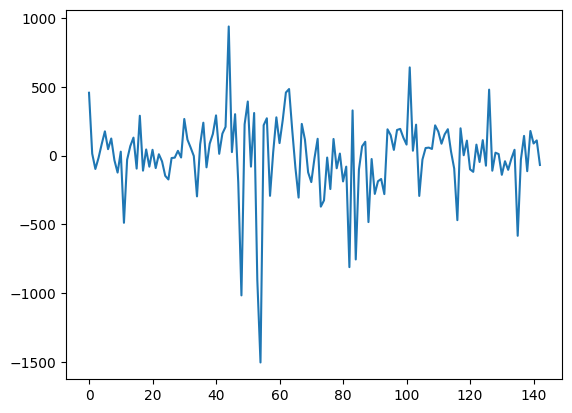

In [315]:
plt.plot(trade_profits)

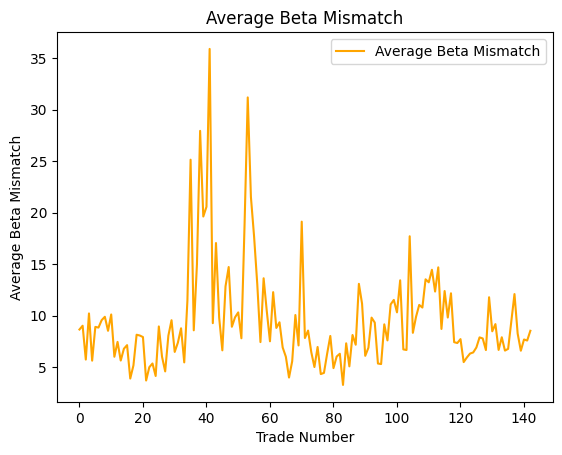

In [316]:
#Plot average beta mismatch
plt.plot(avg_beta_mismatch, color = 'orange', label='Average Beta Mismatch')
plt.title('Average Beta Mismatch')
plt.xlabel('Trade Number')
plt.ylabel('Average Beta Mismatch')
plt.legend()
plt.show()

In [317]:
#Compute leg assymetry for each trade 
#-------------------------------------------


#Change in S1 and S2 from entry to exit (taking into account the beta) 
S1_abs_price_change_trade_ranges = [abs(S1[exit] - S1[entry]) for entry, exit in zip(entry_times, exit_times)]

S2_abs_price_change_trade_ranges = [abs(beta_series[entry]) * abs(S2[exit] - S2[entry]) for entry, exit in zip(entry_times, exit_times)] #Scale the change in S2 by the beta at entry time to take into account the delta neutral position

s1_zero_change_indeces = [i for i, change in enumerate(S1_abs_price_change_trade_ranges) if change == 0]
s2_zero_change_indeces = [i for i, change in enumerate(S2_abs_price_change_trade_ranges) if change == 0]

print(f"S1 zero change indices: {s1_zero_change_indeces}")

print(f"S2 zero change indices: {s2_zero_change_indeces}")

#Check if changes are equall to zero and if so replace it with 0.0001
S1_abs_price_change_trade_ranges = [change if change != 0 else 0.0001 for change in S1_abs_price_change_trade_ranges]
S2_abs_price_change_trade_ranges = [change if change != 0 else 0.0001 for change in S2_abs_price_change_trade_ranges]

# #Drop 0 changes
# S1_abs_trade_ranges_prices = [change for change in S1_abs_trade_ranges_prices if change != 0]
# S2_abs_trade_ranges_prices = [change for change in S2_abs_trade_ranges_prices if change != 0]

#Percent change in S1 and S2 from entry to exit
S1_percentage_price_change_trade_ranges = [(S1[exit] - S1[entry])/S1[entry] * 100 for entry, exit in zip(entry_times, exit_times)]
S2_percentage_price_change_trade_ranges = [(abs(beta_series[entry]) * (S2[exit] - S2[entry]))/S2[entry] * 100 for entry, exit in zip(entry_times, exit_times)] #Scale the change in S2 by the beta at entry time to take into account the delta neutral position



assymetry_ratios = []
bigger_legs = []

for S1_abs_change, S2_abs_change in zip(S1_abs_price_change_trade_ranges, S2_abs_price_change_trade_ranges):
    
    if S1_abs_change > S2_abs_change:
        assymetry_ratio = S1_abs_change / S2_abs_change
        assymetry_ratios.append(assymetry_ratio)
        bigger_leg = 'S1'
        bigger_legs.append(bigger_leg)
    else:
        assymetry_ratio = S2_abs_change / S1_abs_change
        assymetry_ratios.append(assymetry_ratio)
        bigger_leg = 'S2'
        bigger_legs.append(bigger_leg)



S1 zero change indices: []
S2 zero change indices: [22]


In [318]:
S2_abs_price_change_trade_ranges[0]

np.float64(0.006966988829665316)

In [319]:
S2[entry_times][0]

/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_17927/2586190282.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S2[entry_times][0]


np.float64(0.02885)

In [320]:
#Get index of max assymetry ratio
max_assymetry_index = assymetry_ratios.index(max(assymetry_ratios))
max_assymetry_index

93

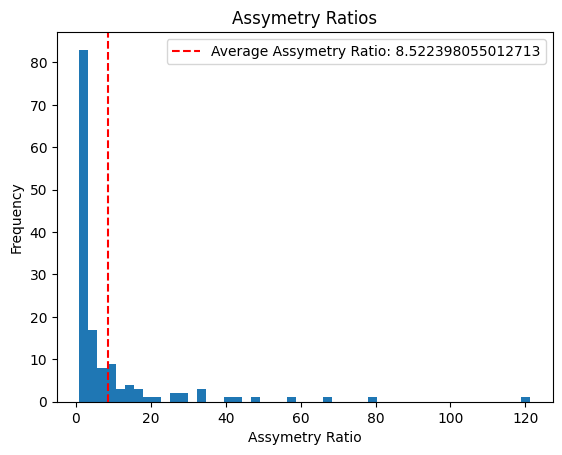

In [321]:
plt.hist(assymetry_ratios, bins=50)
plt.axvline(x=np.mean(assymetry_ratios), color='r', linestyle='--', label=f'Average Assymetry Ratio: {np.mean(assymetry_ratios)}')
plt.title('Assymetry Ratios')
plt.xlabel('Assymetry Ratio')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [322]:
#Zip trade_profits, positions,entry_betas, avg_beta_mismatch, assymetry_ratios, bigger_legs, S1_percentage_price_change_trade_ranges, S2_percentage_price_change_trade_ranges, trade_duration with labels

#print lengths of lists to ensure algined shapes



positions = [entry['position'] for entry in trade_entries]
trade_durations = [(exit_time - entry_time).total_seconds() / 60 for entry_time, exit_time in zip(entry_times, exit_times)]

print(f"Trade profits length: {len(trade_profits)}")
print(f"Positions: {len(positions)}")
print(f"Beta_entry: {len(entry_betas)}")
print(f"avg_beta_mismatchlength: {len(avg_beta_mismatch)}")
print(f"max_beta_mismatch: {len(max_beta_mismatch)}")
print(f"assymetry_ratios: {len(assymetry_ratios)}")
print(f"bigger_legs: {len(bigger_legs)}")
print(f"S1_percentage_changes: {len(S1_percentage_price_change_trade_ranges)}")
print(f"S2_percentage_changes: {len(S2_percentage_price_change_trade_ranges)}")
print(f"Trade duration (minutes): {len(trade_durations)}")



trade_data = list(zip(trade_profits, positions,entry_betas, avg_beta_mismatch,max_beta_mismatch, assymetry_ratios, bigger_legs, S1_percentage_price_change_trade_ranges, S2_percentage_price_change_trade_ranges, trade_durations))
trade_data = pd.DataFrame(trade_data, columns=['Trade Profit', 'Position','Entry Beta','Avg Beta Mismatch','Max Beta Mismatch','Assymetry Ratio', 'Bigger Leg', "Percentage Change S1", "Percentage Change S2", "Trade Duration (minutes)"])

#Add column for absolute percenrage profit return, and put it in the second column
trade_data.insert(1, 'Absolute Percentage Profit Return (%)', 0.0)
trade_data['Absolute Percentage Profit Return (%)'] = abs(trade_data['Trade Profit']) / initial_capital * 100

pd.set_option('display.max_columns', None)
trade_data


Trade profits length: 143
Positions: 144
Beta_entry: 143
avg_beta_mismatchlength: 143
max_beta_mismatch: 143
assymetry_ratios: 143
bigger_legs: 143
S1_percentage_changes: 143
S2_percentage_changes: 143
Trade duration (minutes): 143


,Trade Profit,Absolute Percentage Profit Return (%),Position,Entry Beta,Avg Beta Mismatch,Max Beta Mismatch,Assymetry Ratio,Bigger Leg,Percentage Change S1,Percentage Change S2,Trade Duration (minutes)
0,457.309183,4.573092,1,3.415191,8.645599,61.584809,1.033445,S1,-3.744150,-24.149008,42.0
1,14.567509,0.145675,1,10.024139,9.013633,69.975861,1.282618,S1,-0.520833,-2.677183,469.0
2,-97.354177,0.973542,-1,6.092140,5.726502,33.907860,1.818914,S1,-2.510716,-9.063498,100.0
3,-16.368844,0.163688,-1,5.758811,10.207501,54.241189,4.341174,S1,-1.498801,-2.268141,82.0
4,83.871672,0.838717,1,6.655329,5.620487,26.655329,3.327664,S2,0.305064,-6.496807,118.0
...,...,...,...,...,...,...,...,...,...,...,...
138,-113.427989,1.134280,-1,11.907051,8.253832,108.092949,1.454354,S1,-3.081597,-17.081494,254.0
139,178.966734,1.789667,-1,-0.495382,6.585556,40.495382,27.107502,S1,-2.145139,-0.605179,260.0
140,88.092156,0.880922,-1,-0.676159,7.676871,50.676159,42.889333,S1,-1.326017,-0.233965,480.0
141,110.360811,1.103608,-1,6.691725,7.575645,96.691725,3.250267,S2,-0.338001,8.537285,374.0


In [323]:
#Remove big leg column from trade data
trade_data_no_big_leg = trade_data.drop(columns=['Bigger Leg'])

corr = trade_data_no_big_leg.corr()
print(corr['Absolute Percentage Profit Return (%)'].sort_values())

Trade Profit                            -0.391509
Percentage Change S1                     0.056391
Position                                 0.068849
Assymetry Ratio                          0.099039
Entry Beta                               0.145559
Trade Duration (minutes)                 0.184598
Avg Beta Mismatch                        0.216029
Max Beta Mismatch                        0.278875
Percentage Change S2                     0.417655
Absolute Percentage Profit Return (%)    1.000000
Name: Absolute Percentage Profit Return (%), dtype: float64


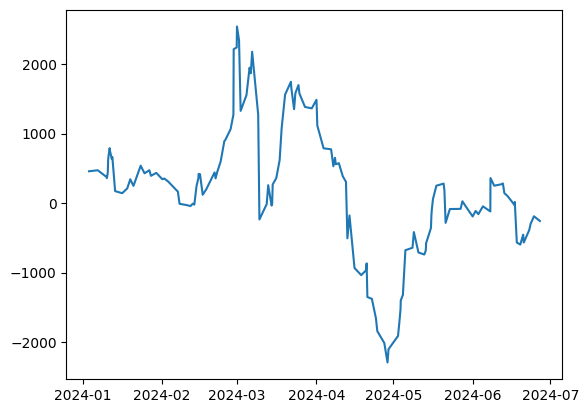

In [324]:
plt.plot(cumulative_profit_series)

In [325]:
#Summarize measures and save them

#Total trade return
total_trade_return = np.sum(trade_profits) / initial_capital * 100

print(f"Total trade return (%): {total_trade_return}")

#Average return 
trade_returns  = [(trade_profit / initial_capital) * 100 for trade_profit in trade_profits]
average_return = np.mean(trade_returns)
print(f"Average trade return (%): {average_return}")

#Max drawdown
print(f"Max drawdown (%): {max_drawdown:.2f}")

#Total number of trades
total_trades = len(trade_profits)
print(f"Total number of trades: {total_trades}")


sum_net_profits_S1 = np.sum(net_trade_profits_S1)
sum_net_profits_S2 = np.sum(net_trade_profits_S2)

percentage_contribution_S1 = (sum_net_profits_S1 / cumulative_profit_series[-1]) * 100
percentage_contribution_S2 = (sum_net_profits_S2 / cumulative_profit_series[-1]) * 100

print(f"Total net profit: {cumulative_profit_series[-1]}")
print(f"Total profit from S1 leg: {sum_net_profits_S1:.2f}")
print(f"Total profit from S2 leg: {sum_net_profits_S2:.2f}")

print(f"Percentage contribution from S1 leg: {percentage_contribution_S1:.2f}%")
print(f"Percentage contribution from S2 leg: {percentage_contribution_S2:.2f}%")

#Standard deviation of returns
trade_std = np.std(trade_returns)
print(f"Standard deviation of trade returns (%): {trade_std}")

#S1 and S2 standard deviation
#-------------------------------------------
S1_returns = S1.pct_change().dropna() #Gives the percentage change in decimal form
S2_returns = S2.pct_change().dropna()
S1_std = S1_returns.std() * 100 #Multiply by 100 to get percentage
S2_std = S2_returns.std() * 100 #Multiply by 100 to get percentage
print(f"Standard deviation of S1 returns (%): {S1_std}")
print(f"Standard deviation of S2 returns (%): {S2_std}")


print(f"volatility_ratio S1 to S2: {S1_std/S2_std}")

#Average trade duration
average_trade_duration = np.mean(trade_durations)
print(f"Average trade duration (minutes): {average_trade_duration}")

#Average entry beta
average_entry_beta = np.mean(entry_betas)
print(f"Average entry beta: {average_entry_beta}")

#Average beta mismatch
average_beta_mismatch = np.mean(avg_beta_mismatch)
print(f"Average beta mismatch: {average_beta_mismatch}")

#Average max beta mismatch
average_max_beta_mismatch = np.mean(max_beta_mismatch)
print(f"Average Maximum beta mismatch: {max_beta_mismatch}")

#Average assymetry ratio
avgerage_assymetry_ratio = np.mean(assymetry_ratios)
print(f"Average assymetry ratio: {avgerage_assymetry_ratio}")

#Average trade percent change in S1 and S2
average_S1_percentage_change = np.mean(S1_percentage_price_change_trade_ranges)
print(f"Average trade percent change in S1 (%): {average_S1_percentage_change}")
average_S2_percentage_change = np.mean(S2_percentage_price_change_trade_ranges) #Note this was computed taking into account the beta
print(f"Average trade percent change in S2 (%): {average_S2_percentage_change}") 

#Standard deviation of spread series returns
spread_series_returns = spread_series.pct_change().dropna()
spread_series_std = spread_series_returns.std() * 100 #Multiply by 100 to get percentage
print(f"Standard deviation of spread series returns (%): {spread_series_std}")


#Standard deviation of Beta series returns 
beta_series_returns = beta_series.pct_change().dropna()
beta_series_std = beta_series_returns.std() * 100 #Multiply by 100 to get percentage
print(f"Standard deviation of beta series returns (%): {beta_series_std}")

#Average spread series

average_spread_series = np.mean(spread_series)
print(f"Average spread series: {average_spread_series}")

#Create a dataframe to store the summary of measures above

summary_measures = {
    'Pair': f"{sym1} ~ {sym2}",
    'Total Trade Return (%)': total_trade_return,
    'Average Trade Return (%)': average_return,
    'Standard Deviation of Trade Returns (%)': trade_std,
    'Max Drawdown (%)': max_drawdown,
    'Total number of trades': total_trades,
    'Total Net Profit (€)': cumulative_profit_series[-1],
    'Total Profit from S1 Leg (€)': sum_net_profits_S1,
    'Total Profit from S2 Leg (€)': sum_net_profits_S2,
    'Percentage Contribution from S1 Leg (%)': percentage_contribution_S1,
    'Percentage Contribution from S2 Leg (%)': percentage_contribution_S2,
    'Standard Deviation of S1 Returns (%)': S1_std,
    'Standard Deviation of S2 Returns (%)': S2_std,
    'Volatility_ratio S1 to S2': S1_std/S2_std,
    'Average Trade Duration (minutes)': average_trade_duration,
    'Average Entry Beta': average_entry_beta,
    'Average Beta Mismatch': average_beta_mismatch,
    'Average Maximum Beta Mismatch': average_max_beta_mismatch,
    'Average Assymetry Ratio': avgerage_assymetry_ratio,
    'Average Trade Percent Change in S1 (%)': average_S1_percentage_change,
    'Average Trade Percent Change in S2 (%)': average_S2_percentage_change,
    'Average Spread Series': average_spread_series,
    'Standard Deviation of Spread Series Returns (%)': spread_series_std,
    'Standard Deviation of Beta Series Returns (%)': beta_series_std
}

#Save to dataframe with the index as the pair name
summary_measures_df = pd.DataFrame(summary_measures, index=[0])

#Save to csv

#Clean the file names
def clean_filename_component(s):
    return s.replace('/', '_').replace('\\', '_')  # Add more replacements if needed

# Example symbols
sym1_clean = clean_filename_component(sym1)
sym2_clean = clean_filename_component(sym2)

# Create folder
folder_path = 'results'
os.makedirs(folder_path, exist_ok=True)

# Create clean path
file_path = os.path.join(folder_path, f'summary_measures {sym1_clean} and {sym2_clean}.csv')

# Save the DataFrame
summary_measures_df.to_csv(file_path, index=False)



Total trade return (%): -2.5781598976342
Average trade return (%): -0.01802909019324601
Max drawdown (%): -190.27
Total number of trades: 143
Total net profit: -257.8159897634201
Total profit from S1 leg: 78.49
Total profit from S2 leg: -336.31
Percentage contribution from S1 leg: -30.44%
Percentage contribution from S2 leg: 130.44%
Standard deviation of trade returns (%): 2.8701373560624206
Standard deviation of S1 returns (%): 0.16082806755026738
Standard deviation of S2 returns (%): 0.17829722298039802
volatility_ratio S1 to S2: 0.902022279774648
Average trade duration (minutes): 334.65734265734267
Average entry beta: 4.8800434077338615
Average beta mismatch: 9.495024295647116
Average Maximum beta mismatch: [np.float64(61.584809397225314), np.float64(69.97586136676362), np.float64(33.907859731939965), np.float64(54.24118908548181), np.float64(26.655328908784014), np.float64(51.29121994098368), np.float64(63.359167269190586), np.float64(52.47435043405935), np.float64(52.3183197994465

/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_17927/1336247746.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage_contribution_S1 = (sum_net_profits_S1 / cumulative_profit_series[-1]) * 100
/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_17927/1336247746.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage_contribution_S2 = (sum_net_profits_S2 / cumulative_profit_series[-1]) * 100
/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_17927/1336247746.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys

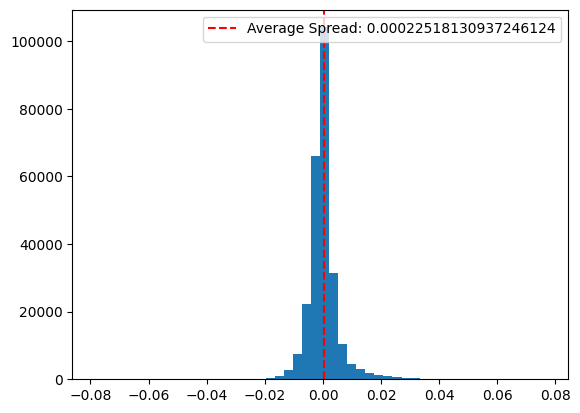

In [326]:
plt.hist(spread_series, bins=50)
plt.axvline(x=np.mean(spread_series), color='r', linestyle='--', label=f'Average Spread: {np.mean(spread_series)}')
plt.legend()

In [327]:
max_beta_mismatch

[np.float64(61.584809397225314),
 np.float64(69.97586136676362),
 np.float64(33.907859731939965),
 np.float64(54.24118908548181),
 np.float64(26.655328908784014),
 np.float64(51.29121994098368),
 np.float64(63.359167269190586),
 np.float64(52.47435043405935),
 np.float64(52.318319799446506),
 np.float64(66.70892882877885),
 np.float64(56.00675495687484),
 np.float64(55.567696295687206),
 np.float64(126.17805358976773),
 np.float64(34.64365792398215),
 np.float64(43.170978960151245),
 np.float64(95.09758607954474),
 np.float64(23.377370590990093),
 np.float64(33.913355779824904),
 np.float64(23.471650279322755),
 np.float64(76.67483638054442),
 np.float64(25.94629613396162),
 np.float64(15.018227666882114),
 np.float64(15.189896434208295),
 np.float64(42.27755260062642),
 np.float64(50.73698705346779),
 np.float64(50.25541747410646),
 np.float64(81.22647521672624),
 np.float64(29.59431912669629),
 np.float64(43.23362473376916),
 np.float64(59.85724120283328),
 np.float64(34.571171402293

In [328]:
summary_measures_df

,Pair,Total Trade Return (%),Average Trade Return (%),Standard Deviation of Trade Returns (%),Max Drawdown (%),Total number of trades,Total Net Profit (€),Total Profit from S1 Leg (€),Total Profit from S2 Leg (€),Percentage Contribution from S1 Leg (%),Percentage Contribution from S2 Leg (%),Standard Deviation of S1 Returns (%),Standard Deviation of S2 Returns (%),Volatility_ratio S1 to S2,Average Trade Duration (minutes),Average Entry Beta,Average Beta Mismatch,Average Maximum Beta Mismatch,Average Assymetry Ratio,Average Trade Percent Change in S1 (%),Average Trade Percent Change in S2 (%),Average Spread Series,Standard Deviation of Spread Series Returns (%),Standard Deviation of Beta Series Returns (%)
0,GRT/USDT_2024_1m ~ GALA/USDT_2024_1m,-2.57816,-0.018029,2.870137,-190.268694,143,-257.81599,78.489569,-336.305559,-30.444027,130.444027,0.160828,0.178297,0.902022,334.657343,4.880043,9.495024,93.344931,8.522398,0.119045,1.780246,0.000225,3146.481908,51.84628


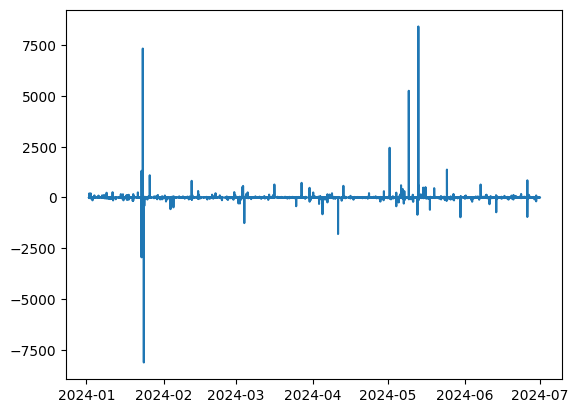

In [329]:
plt.plot(spread_series_returns)

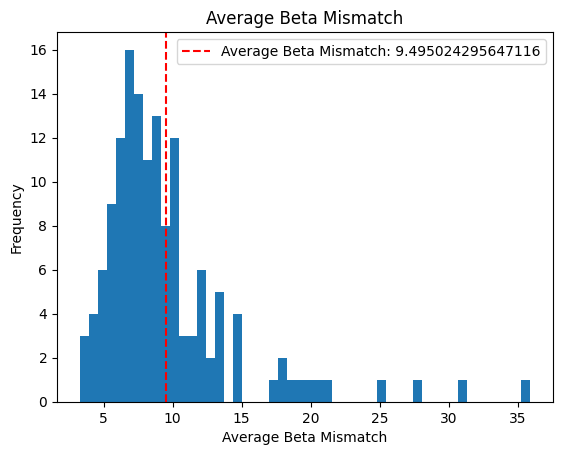

In [330]:
plt.hist(avg_beta_mismatch, bins=50)
plt.axvline(x=np.mean(avg_beta_mismatch), color='r', linestyle='--', label=f'Average Beta Mismatch: {np.mean(avg_beta_mismatch)}')
plt.title('Average Beta Mismatch')
plt.xlabel('Average Beta Mismatch')
plt.ylabel('Frequency') 
plt.legend()

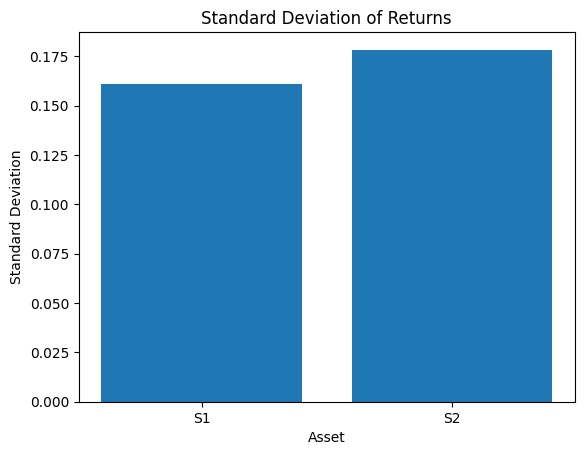

In [331]:

#Plot differnce in volatility of S1 and S2 in a bar chart
plt.bar(['S1', 'S2'], [S1_std, S2_std])
plt.title('Standard Deviation of Returns')
plt.xlabel('Asset')
plt.ylabel('Standard Deviation')
plt.show()



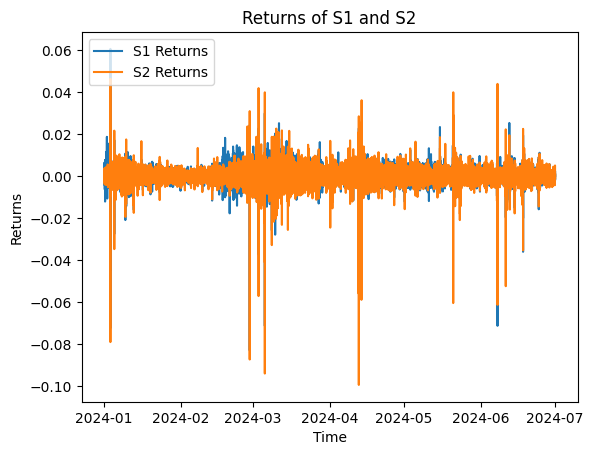

In [332]:
plt.plot(S1_returns, label='S1 Returns')
plt.plot(S2_returns, label='S2 Returns')
plt.legend(loc='upper left')
plt.title('Returns of S1 and S2')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.show()
#Plot the trade data

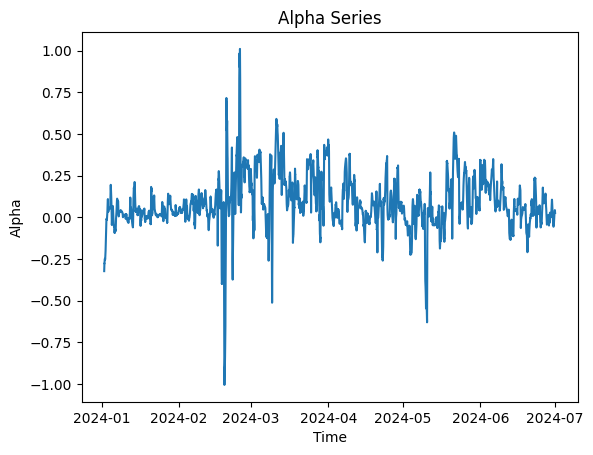

In [333]:
plt.plot(alpha_series)
plt.title('Alpha Series')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.show()


In [334]:
bigger_legs_S1 = [leg for leg in bigger_legs if leg == 'S1']
bigger_legs_S2 = [leg for leg in bigger_legs if leg == 'S2']
print(f"Number of trades with bigger leg S1: {len(bigger_legs_S1)}")
print(f"Number of trades with bigger leg S2: {len(bigger_legs_S2)}")

#Percentage of trades with bigger leg S1 and S2
percentage_bigger_leg_S1 = len(bigger_legs_S1) / len(bigger_legs) * 100
percentage_bigger_leg_S2 = len(bigger_legs_S2) / len(bigger_legs) * 100
print(f"Percentage of trades with bigger leg S1: {percentage_bigger_leg_S1}%")
print(f"Percentage of trades with bigger leg S2: {percentage_bigger_leg_S2}%")

Number of trades with bigger leg S1: 85
Number of trades with bigger leg S2: 58
Percentage of trades with bigger leg S1: 59.44055944055944%
Percentage of trades with bigger leg S2: 40.55944055944056%


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  4.,  2.,  1.,
         0.,  4.,  2.,  2.,  4., 11.,  6.,  3., 11.,  4., 10., 10.,  5.,
         6., 10.,  3.,  5.,  6.,  5.,  2.,  4.,  3.,  1.,  1.,  0.,  1.,
         0.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-1505.58266357, -1481.13031033, -1456.6779571 , -1432.22560387,
        -1407.77325064, -1383.3208974 , -1358.86854417, -1334.41619094,
        -1309.96383771, -1285.51148447, -1261.05913124, -1236.60677801,
        -1212.15442477, -1187.70207154, -1163.24971831, -1138.79736508,
        -1114.34501184, -1089.89265861, -1065.44030538, -1040.98795215,
        -1016.53559891,  -992.08324568,  -967.63089245,  -943.17853921,
  

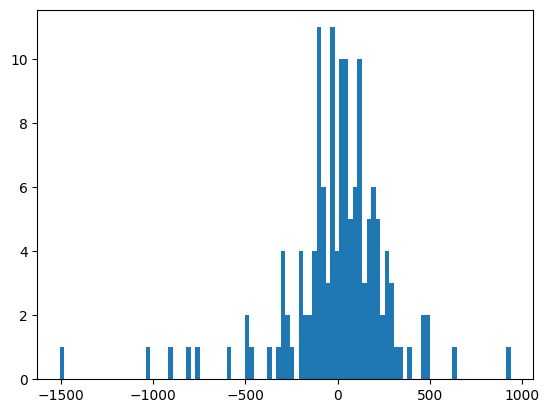

In [335]:
plt.hist(trade_profits, bins=100)

In [336]:
#Filter for negative values

trade_profits_neg = [x for x in trade_profits if x < 0]
print(f"Average trade loss:  € {np.mean(trade_profits_neg)}")

trade_profits_pos = [x for x in trade_profits if x > 0]
print(f"Average trade win:  € {np.mean(trade_profits_pos)}")

print("Number of negative profits(profits that were less than the transaction cost): ", len(trade_profits_neg))
print("Number of positive profits (profits that were greater than the transaction cost): ", len(trade_profits_pos))



Average trade loss:  € -214.83875981900286
Average trade win:  € 165.96282348542204
Number of negative profits(profits that were less than the transaction cost):  63
Number of positive profits (profits that were greater than the transaction cost):  80


In [337]:
#Get index of greatest loss
max_loss_index = trade_profits.index(min(trade_profits))
max_loss_index

54

In [338]:
trade_entries[max_loss_index]

{'time': Timestamp('2024-03-09 09:47:00'),
 'S1': np.float64(0.409),
 'S2': np.float64(0.0482),
 'z': np.float64(-3.0783208978094914),
 'position': 1}

In [339]:
trade_exits[max_loss_index]

{'time': Timestamp('2024-03-09 20:16:00'),
 'S1': np.float64(0.4003),
 'S2': np.float64(0.05575),
 'z': np.float64(0.011165427716733378),
 'exit_type': 'win'}

In [340]:
print(f"MAX LOSS: {trade_profits[max_loss_index]}")

MAX LOSS: -1505.5826635669723


In [341]:
#Get trade entry and exit times
trade_entry_min_profit = entry_times[max_loss_index],
trade_exit_min_profit = exit_times[max_loss_index]

print(f"Trade entry time: {trade_entry_min_profit}")
print(f"Trade exit time: {trade_exit_min_profit}")

Trade entry time: (Timestamp('2024-03-09 09:47:00'),)
Trade exit time: 2024-03-09 20:16:00


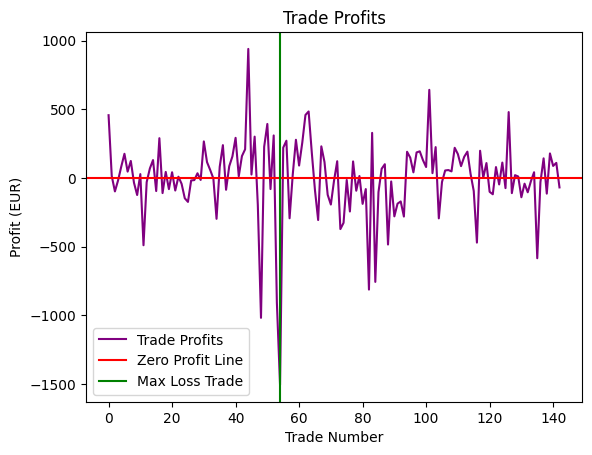

In [342]:
plt.plot(trade_profits, label='Trade Profits', color = 'purple')
plt.axhline(y=0, color='r', linestyle='-', label='Zero Profit Line')
plt.axvline(x=max_loss_index, color='g', linestyle='-', label='Max Loss Trade')
plt.title('Trade Profits')
plt.xlabel('Trade Number')
plt.ylabel('Profit (EUR)')
plt.legend()

Average trade duration: 334.66 minutes


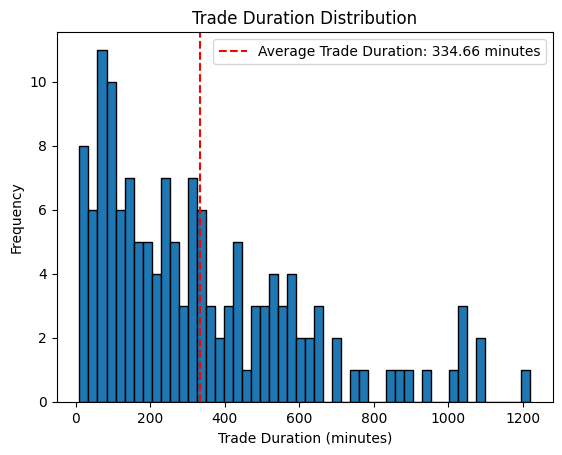

In [343]:
#Calculate the durations of all the trades
#trade_durations = [exit - entry for entry, exit in zip(entry_times, exit_times)]
trade_durations = [(exit_time - entry_time).total_seconds() / 60 for entry_time, exit_time in zip(entry_times, exit_times)]

average_trade_duration = np.mean(trade_durations)
print(f"Average trade duration: {average_trade_duration:.2f} minutes")
#Plot distribution of trade durations
plt.hist(trade_durations, bins=50, edgecolor='black')
plt.axvline(x=average_trade_duration, color='red', linestyle='--', label=f'Average Trade Duration: {average_trade_duration:.2f} minutes')
plt.xlabel('Trade Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Trade Duration Distribution')
plt.legend()
plt.show()

In [344]:
trade_durations[max_assymetry_index]

935.0

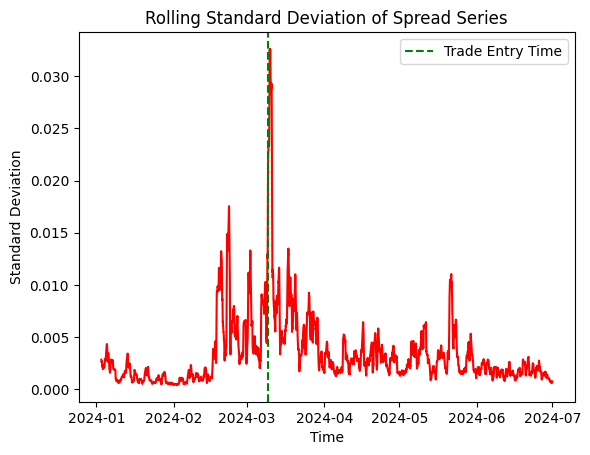

In [345]:
plt.plot(rolling_std, color = 'red')
plt.axvline(trade_entry_min_profit, color='green', linestyle='--', label='Trade Entry Time')
plt.xlabel('Time')
plt.ylabel('Standard Deviation')
plt.title('Rolling Standard Deviation of Spread Series')
plt.legend()


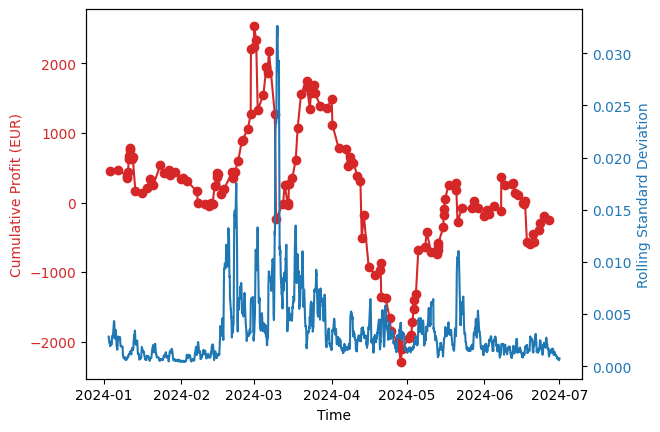

In [346]:
#Plot cumulative profit series and rolling standard deviation on same plot

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')      
ax1.set_ylabel('Cumulative Profit (EUR)', color=color)
ax1.plot(cumulative_profit_series, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Rolling Standard Deviation', color=color)
ax2.plot(rolling_std, color=color)
ax2.tick_params(axis='y', labelcolor=color) 


# Hypothesis: Big swings in returns are caused by over exposure to one side of the market due to entry using a "whipsawed Beta" + a big percentage price move over the trade
---

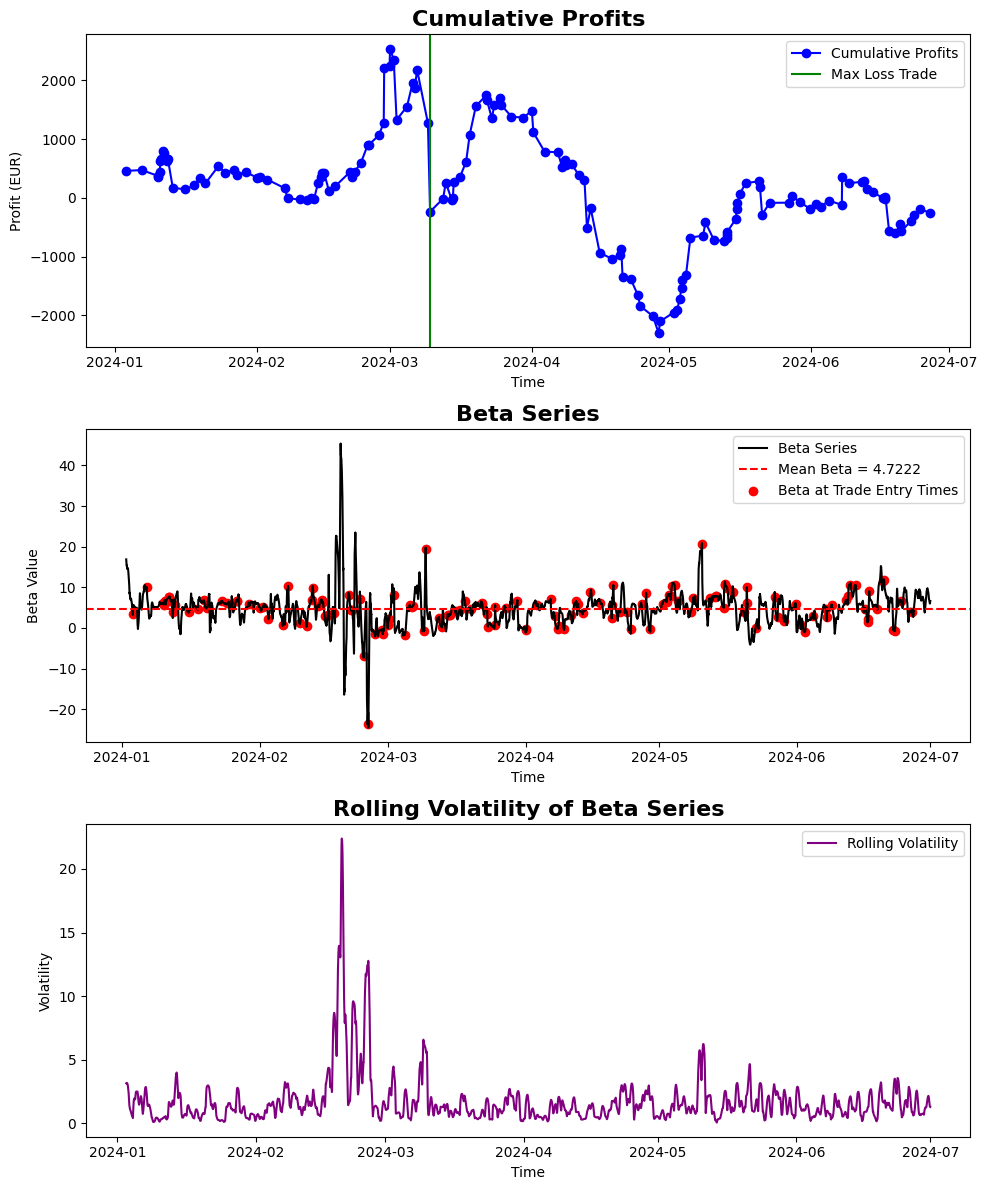

In [347]:
# Create a figure for stacked plots
plt.figure(figsize=(10, 12))

# First subplot: Cumulative Profits
plt.subplot(3, 1, 1)
plt.plot(cumulative_profit_series, label='Cumulative Profits', color='Blue', marker = 'o')
plt.axvline(x=trade_exit_min_profit, color='g', linestyle='-', label='Max Loss Trade')
plt.title('Cumulative Profits', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Profit (EUR)')
plt.legend()


# # First subplot: Trade Profits
# plt.subplot(4, 1, 2)
# plt.plot(trade_profits, label='Trade Profits', color='Green', marker='o')
# plt.title('Trade Profits', fontsize=16, fontweight='bold')
# plt.xlabel('Trade Number')
# plt.ylabel('Profit (EUR)')
# plt.legend()


# Second subplot: Beta Series with Mean Line
plt.subplot(3, 1, 2)
mean_beta = np.mean(beta_series)
plt.plot(beta_series, color='black', label='Beta Series')
plt.axhline(y=mean_beta, color='red', linestyle='--', label=f'Mean Beta = {mean_beta:.4f}')
plt.scatter(entry_times, [beta_series.loc[entry] for entry in entry_times], color='red', label='Beta at Trade Entry Times')
plt.title('Beta Series', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Beta Value')
plt.legend()

# Third subplot: Rolling Volatility of Beta Series
# Adjust the layout to 4 rows and 1 column
plt.subplot(3, 1, 3)
rolling_volatility = beta_series.rolling(window_size).std()
plt.plot(rolling_volatility, color='purple', label='Rolling Volatility')
plt.title('Rolling Volatility of Beta Series', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

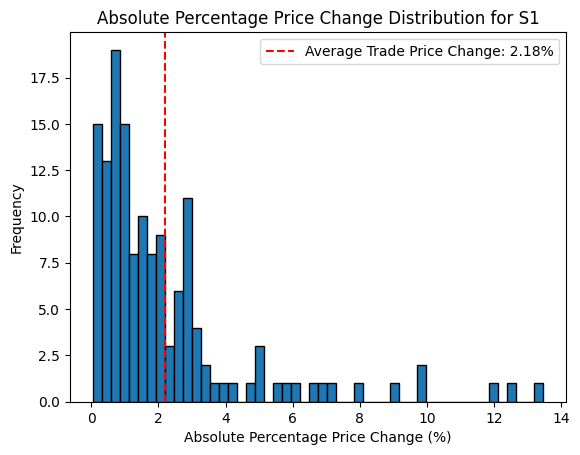

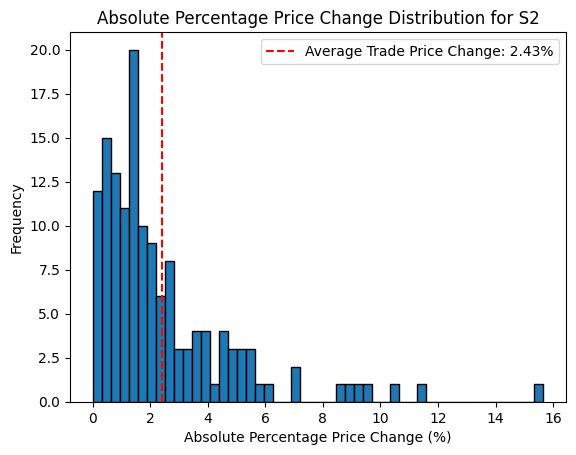

In [348]:

#Zip Beta at entries profits per trade and trade duration together 
beta_at_entries_profits = list(zip(beta_series.loc[entry_times], trade_profits, trade_durations))

#Calculate absolute percentage prrice change of S1 and S2 for each trade
abs_percentage_trade_price_change_S1 = [(abs(S1.loc[exit_time] - S1.loc[entry_time])/S1.loc[entry_time])*100  for entry_time, exit_time in zip(entry_times, exit_times)]
abs_percentage_trade_price_change_S2 = [(abs(S2.loc[exit_time] - S2.loc[entry_time])/S2.loc[entry_time])*100 for entry_time, exit_time in zip(entry_times, exit_times)]

#Distribution of absolute percentage price changes
plt.hist(abs_percentage_trade_price_change_S1, bins=50, edgecolor='black')
plt.axvline(x=np.mean(abs_percentage_trade_price_change_S1), color='red', linestyle='--', label=f'Average Trade Price Change: {np.mean(abs_percentage_trade_price_change_S1):.2f}%')
plt.xlabel('Absolute Percentage Price Change (%)')
plt.ylabel('Frequency')
plt.title('Absolute Percentage Price Change Distribution for S1')
plt.legend()
plt.show()

plt.hist(abs_percentage_trade_price_change_S2, bins=50, edgecolor='black')
plt.axvline(x=np.mean(abs_percentage_trade_price_change_S2), color='red', linestyle='--', label=f'Average Trade Price Change: {np.mean(abs_percentage_trade_price_change_S2):.2f}%')
plt.xlabel('Absolute Percentage Price Change (%)')
plt.ylabel('Frequency')
plt.title('Absolute Percentage Price Change Distribution for S2')
plt.legend()
plt.show()



In [349]:
#Check correlation between sign of trade profits and beta at entries
trade_profits_sign = [1 if profit > 0 else -1 for profit in trade_profits]

beta__entries_sign = [1 if beta > 0 else -1 for beta in beta_series.loc[entry_times]]


#Count the number of times where the the profit is negative for a negative beta and positive for a positive beta

count_neg_beta_neg_profit = sum(1 for profit, beta in zip(trade_profits_sign, beta__entries_sign) if profit == -1 and beta == -1)
count_pos_beta_pos_profit = sum(1 for profit, beta in zip(trade_profits_sign, beta__entries_sign) if profit == 1 and beta == 1)
count_neg_beta_pos_profit = sum(1 for profit, beta in zip(trade_profits_sign, beta__entries_sign) if profit == 1 and beta == -1)
count_pos_beta_neg_profit = sum(1 for profit, beta in zip(trade_profits_sign, beta__entries_sign) if profit == -1 and beta == 1)
print(f"Count of negative beta and negative profit: {count_neg_beta_neg_profit}")
print(f"Count of positive beta and positive profit: {count_pos_beta_pos_profit}")
print(f"Count of negative beta and positive profit: {count_neg_beta_pos_profit}")
print(f"Count of positive beta and negative profit: {count_pos_beta_neg_profit}")



Count of negative beta and negative profit: 4
Count of positive beta and positive profit: 67
Count of negative beta and positive profit: 13
Count of positive beta and negative profit: 59


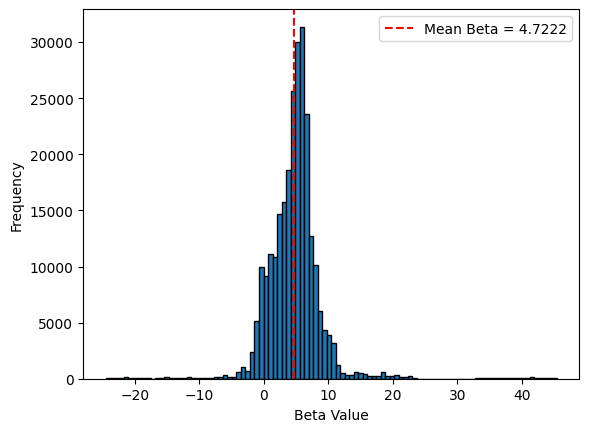

In [350]:
#Plot the distribution of beta series



plt.hist(beta_series, bins=100, edgecolor='black')
plt.axvline(x=np.mean(beta_series), color='red', linestyle='--', label=f'Mean Beta = {mean_beta:.4f}')
plt.xlabel('Beta Value')
plt.ylabel('Frequency')
plt.legend()

In [351]:
beta_series

timestamp
2024-01-01 00:00:00         NaN
2024-01-01 00:01:00         NaN
2024-01-01 00:02:00         NaN
2024-01-01 00:03:00         NaN
2024-01-01 00:04:00         NaN
                         ...   
2024-06-30 23:55:00    6.613771
2024-06-30 23:56:00    6.620831
2024-06-30 23:57:00    6.627404
2024-06-30 23:58:00    6.633565
2024-06-30 23:59:00    6.639552
Length: 262080, dtype: float64

# Relationship between returns volatility and Beta volatility
---

In [352]:
from scipy import stats


trade_ranges = [(entry, exit) for entry, exit in zip(entry_times, exit_times)]

#Get beta series in the trade ranges
beta_series_trade_ranges = [beta_series[entry:exit] for entry, exit in trade_ranges]

#Calcullate the volatility of the beta series in the trade ranges
volatility_trade_ranges = [np.std(beta_series_trade_range) for beta_series_trade_range in beta_series_trade_ranges]

#Calculate range of the beta series in the trade ranges
abs_beta_trade_ranges = [np.abs(np.max(beta_series_trade_range) - np.min(beta_series_trade_range)) for beta_series_trade_range in beta_series_trade_ranges]

#Calculate the absolute returns for each trade
absolute_trade_returns = [np.abs(trade_profit/initial_capital) for trade_profit in trade_profits]

#-------------------------------------------


# #Perform linear regression to determine if there is a relationship between absolute returns and volatility
# slope, intercept, r_value, p_value, std_err = stats.linregress(volatility_trade_ranges, absolute_trade_returns)
# print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R-squared: {r_value**2:.4f}, P-value: {p_value:.4f}, Standard Error: {std_err:.4f}")

# if p_value < 0.05:
#     print("There is a significant relationship between absolute returns and volatility")
# else:
#     print("There is no significant relationship between absolute returns and volatility")

# #Plot the relationship between absolute returns and volatility with a linear regression line
# plt.scatter(volatility_trade_ranges, absolute_trade_returns)
# plt.plot(volatility_trade_ranges, [slope*volatility_val + intercept for volatility_val in volatility_trade_ranges], color='red', label='Linear Regression')
# plt.xlabel('Beta Volatility')
# plt.ylabel('Absolute Returns')
# plt.title('Absolute Returns vs Volatility')
# plt.legend()
# plt.show()

#-------------------------------------------



Text(0.5, 1.0, 'Absolute Returns vs Beta Range')

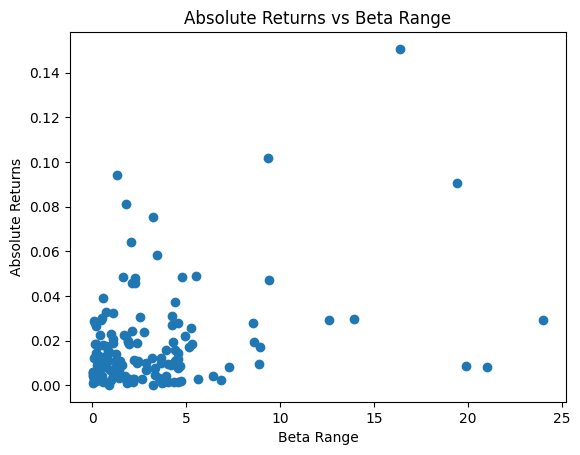

In [353]:
#Plot absolute_trade_returns vs abs_beta_trade_ranges
plt.scatter(abs_beta_trade_ranges, absolute_trade_returns)
plt.xlabel('Beta Range')
plt.ylabel('Absolute Returns')
plt.title('Absolute Returns vs Beta Range')

# Delta Neutrality 
---

Slope: 0.0059
Intercept: 0.0097
R-squared: 0.2575
P-value: 0.0000


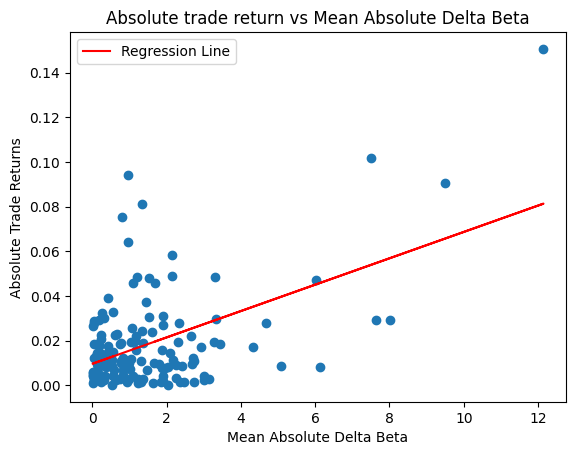

In [354]:
#Plot trade profits vs absolute delta neutrality

from scipy import stats

#Get actual Betas used for each trade entry
beta_entries = [beta_series[entry] for entry in entry_times]

trade_ranges = [(entry, exit) for entry, exit in zip(entry_times, exit_times)]

#Get beta series in the trade ranges

beta_series_trade_ranges = [beta_series[entry:exit].iloc[1:] for entry, exit in trade_ranges] #iloc[1:] to exclude the first beta value which is the same as the entry beta

#Calculate the absolute difference between the beta at the trade entry and the betas in the trade range
absolute_delta_betas = [np.abs(entry_beta - beta_range) for entry_beta, beta_range in zip(beta_entries, beta_series_trade_ranges)]

#Calculate the mean delta beta for each trade
mean_absolute_delta_betas = [np.mean(delta) for delta in absolute_delta_betas]


absolute_trade_returns = [np.abs(trade_profit/initial_capital) for trade_profit in trade_profits]

#Perform a regression analysis to determine if there is a relationship between delta neutrality and trade profits
slope, intercept, r_value, p_value, std_err = stats.linregress(mean_absolute_delta_betas, absolute_trade_returns)

print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

#Plot trade profits vs absolute delta neutrality and the regression line

plt.plot(mean_absolute_delta_betas, absolute_trade_returns, 'o',)
plt.plot(mean_absolute_delta_betas, intercept + slope*np.array(mean_absolute_delta_betas), 'r', label='Regression Line')
plt.xlabel('Mean Absolute Delta Beta')
plt.ylabel('Absolute Trade Returns')
plt.title('Absolute trade return vs Mean Absolute Delta Beta')
plt.legend()


Slope: 0.0025
Intercept: 0.0117
R-squared: 0.1509
P-value: 0.0000


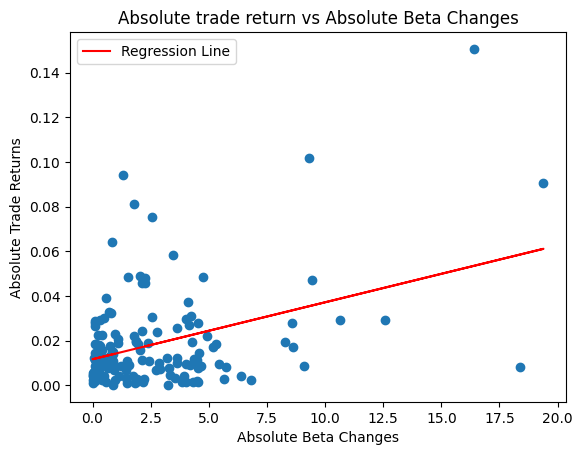

In [355]:
#Get entry beta for each trade
entry_betas = [beta_series[entry] for entry in entry_times]

#Get exit beta for each trade
exit_betas = [beta_series[exit] for exit in exit_times]

#Calculate the absolute difference between the entry and exit betas
absolute_beta_changes = [np.abs(exit - entry) for entry, exit in zip(entry_betas, exit_betas)]

#Regression analysis to determine if there is a relationship between beta changes and absolute trade returns

slope, intercept, r_value, p_value, std_err = stats.linregress(absolute_beta_changes, absolute_trade_returns)

print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

#Plot trade profits vs absolute beta changes and the regression line

plt.plot(absolute_beta_changes, absolute_trade_returns, 'o',)
plt.plot(absolute_beta_changes, intercept + slope*np.array(absolute_beta_changes), 'r', label='Regression Line')
plt.xlabel('Absolute Beta Changes')
plt.ylabel('Absolute Trade Returns')
plt.title('Absolute trade return vs Absolute Beta Changes')
plt.legend()

In [356]:
len(absolute_beta_changes)

143

In [357]:
#Get entry and exit betas for each trade
entry_betas = [beta_series[entry] for entry in entry_times]
exit_betas = [beta_series[exit] for exit in exit_times]

#Calculate the absolute difference between the entry and exit betas
absolute_beta_changes = [np.abs(exit - entry) for entry, exit in zip(entry_betas, exit_betas)]



In [358]:
# # Create a figure for stacked plots
# plt.figure(figsize=(10, 12))

# # First subplot: Cumulative Profits
# plt.subplot(3, 1, 1)
# plt.plot(absolute_trade_returns, color='Blue')
# plt.title('Absolute trade returns', fontsize=16, fontweight='bold')
# plt.xlabel('Time')
# plt.ylabel('Absolute trade return')
# plt.legend()

# #Second subplot: Mean Absolute Delta Beta
# plt.subplot(3, 1, 2)
# plt.plot(mean_absolute_delta_betas, color='red')
# plt.title('Mean Absolute Delta Beta', fontsize=16, fontweight='bold')
# plt.xlabel('Time')
# plt.ylabel('Mean Absolute Delta Beta')
# plt.legend()

# #Third subplot: Absolute Beta Changes
# plt.subplot(3, 1, 3)
# plt.plot(absolute_beta_changes, color='green')
# plt.title('Absolute Beta Changes', fontsize=16, fontweight='bold')
# plt.xlabel('Time')
# plt.ylabel('Absolute Beta Changes')
# plt.legend()



# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()

Slope: 0.0027
Intercept: 0.6314
R-squared: 0.1557
P-value: 0.0000
There is a significant relationship between trade durations and mean absolute delta beta


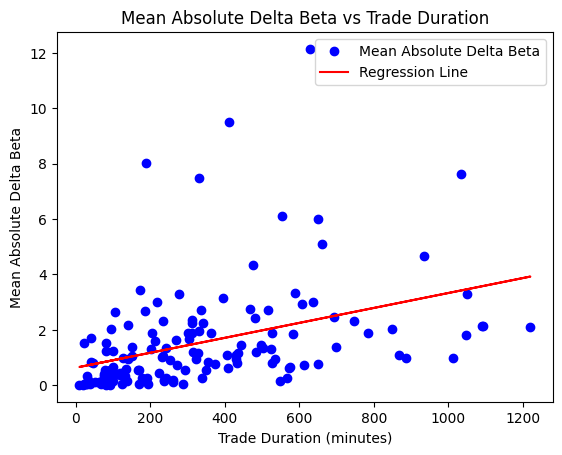

In [359]:
#Plot mean_absolute_delta_betas against trade durations with a regression line

#Perform a regression analysis to determine if there is a relationship between delta neutrality and trade profits
slope, intercept, r_value, p_value, std_err = stats.linregress(trade_durations, mean_absolute_delta_betas)

print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("There is a significant relationship between trade durations and mean absolute delta beta")
else:
    print("There is no significant relationship between trade durations and mean absolute delta beta")


#Plot trade profits vs absolute delta neutrality and the regression line
plt.plot(trade_durations, mean_absolute_delta_betas, 'o', label='Mean Absolute Delta Beta', color='blue')
plt.plot(trade_durations, intercept + slope*np.array(trade_durations), 'r', label='Regression Line')
plt.xlabel('Trade Duration (minutes)')
plt.ylabel('Mean Absolute Delta Beta')
plt.title('Mean Absolute Delta Beta vs Trade Duration')
plt.legend()
plt.show()


In [360]:
len(mean_absolute_delta_betas)

143

In [361]:
#Plot distributions of beta_series_trade_ranges in multiple subplots



In [362]:
len(beta_series_trade_ranges)

143

In [363]:
# #Calculate rolling standard deviation of S1 and S2
# rolling_std_S1 = S1.rolling(window=window_size).std()
# rolling_std_S2 = S2.rolling(window=window_size).std()

# #Plot the rolling standard deviation of S1 and S2 on separate plots

# plt.plot(rolling_std_S1, color='blue')
# plt.xlabel('Time')
# plt.ylabel('Standard Deviation')
# plt.title(f'Rolling Standard Deviation of {sym1}')




In [364]:
# plt.plot(rolling_std_S2, color='green')
# plt.xlabel('Time')
# plt.ylabel('Standard Deviation')
# plt.title(f'Rolling Standard Deviation of {sym2}')

In [365]:
#Get index of negative trade profits
negative_trade_profits_indeices = [i for i, x in enumerate(trade_profits) if x < 0]

#Get the corresponding trade entry and exit times
negative_trade_entry_times = [entry_times[i] for i in negative_trade_profits_indeices]
negative_trade_exit_times = [exit_times[i] for i in negative_trade_profits_indeices]


In [366]:
trade_exit_min_profit

Timestamp('2024-03-09 20:16:00')

In [367]:
#Plot trading simulation

# window_start = pd.to_datetime('2024-03-01 00:00:00')
# window_end = pd.to_datetime('2024-03-25 00:00:00')

#Window for biggest loss
window_start = pd.to_datetime(trade_entry_min_profit[0])
window_end = pd.to_datetime(trade_exit_min_profit)

# window_start = pd.to_datetime('2024-06-17 16:00:00')
# window_end = pd.to_datetime('2024-06-17 16:50:00')


# window_start = None
# window_end = None

#NOTE THAT THE TIMES ON THE X AXIS SHOW THE HOURS AND MINUTES

# S1 = S1_mid_price
# S2 = S2_mid_price

plot_trading_simulation(
    S1, 
    S2, 
    sym1, 
    sym2, 
    zscore_series, 
    positions, 
    trade_profits,
    entry_threshold,
    stop_loss_threshold,
    trade_entries=trade_entries,  # list of dicts: { 'time', 'S1', 'S2', 'z', 'position' }
    trade_exits=trade_exits,    # list of dicts: { 'time', 'S1', 'S2', 'z', 'exit_type' }
    window_start=window_start,
    window_end=window_end
)



AttributeError: 'list' object has no attribute 'loc'

In [115]:
trade_exits

[{'time': Timestamp('2024-01-03 14:36:00'),
  'S1': 0.02638,
  'S2': 0.1822,
  'z': 0.4437793572055555,
  'exit_type': 'win'},
 {'time': Timestamp('2024-01-04 18:33:00'),
  'S1': 0.02781,
  'S2': 0.1931,
  'z': -0.006850665086796985,
  'exit_type': 'win'},
 {'time': Timestamp('2024-01-05 12:46:00'),
  'S1': 0.02661,
  'S2': 0.1854,
  'z': 0.015488705301360182,
  'exit_type': 'win'},
 {'time': Timestamp('2024-01-06 23:04:00'),
  'S1': 0.02594,
  'S2': 0.1703,
  'z': -0.02746432362962432,
  'exit_type': 'win'},
 {'time': Timestamp('2024-01-07 04:17:00'),
  'S1': 0.0266,
  'S2': 0.1732,
  'z': -0.04384630080231934,
  'exit_type': 'win'},
 {'time': Timestamp('2024-01-08 04:01:00'),
  'S1': 0.02312,
  'S2': 0.1528,
  'z': 0.017604863748637723,
  'exit_type': 'win'},
 {'time': Timestamp('2024-01-10 08:41:00'),
  'S1': 0.02449,
  'S2': 0.1591,
  'z': 0.022223017237155054,
  'exit_type': 'win'},
 {'time': Timestamp('2024-01-10 11:15:00'),
  'S1': 0.02548,
  'S2': 0.1655,
  'z': 0.5195951685157

In [116]:
#Check slippage

#Get timestampe of trade entries and exits
entry_times = [x['time'] for x in trade_entries]
exit_times = [x['time'] for x in trade_exits]

#Get the actual entry and exit prices of the two assets at the time of trade entries and exits
S1_actual_entry_prices = [x['S1'] for x in trade_entries]
S2_actual_entry_prices = [x['S2'] for x in trade_entries]

S1_actual_exit_prices = [x['S1'] for x in trade_exits]
S2_actual_exit_prices = [x['S2'] for x in trade_exits]

#Get the mid prices of the two assets at the time of trade entries and exits
S1_entry_mid_prices = S1_mid_price.loc[entry_times]
S2_entry_mid_prices = S2_mid_price.loc[entry_times]

S1_exit_mid_prices = S1_mid_price.loc[exit_times]
S2_exit_mid_prices = S2_mid_price.loc[exit_times]

#Get the slippage for the two assets
S1_entry_slippage_percentage = (S1_actual_entry_prices - S1_entry_mid_prices) / S1_entry_mid_prices * 100
S2_entry_slippage_percentage = (S2_actual_entry_prices - S2_entry_mid_prices) / S2_entry_mid_prices * 100

S1_exit_slippage_percentage = (S1_actual_exit_prices - S1_exit_mid_prices) / S1_exit_mid_prices * 100
S2_exit_slippage_percentage = (S2_actual_exit_prices - S2_exit_mid_prices) / S2_exit_mid_prices * 100


NameError: name 'S1_mid_price' is not defined

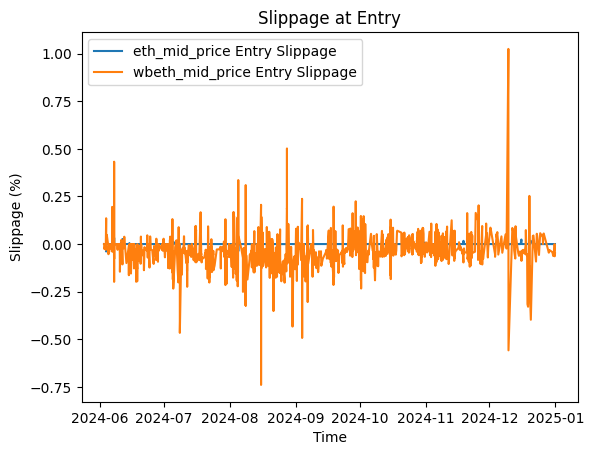

In [ ]:

#Create plots for slippage

plt.plot(S1_entry_slippage_percentage, label=f'{sym1} Entry Slippage')
plt.plot(S2_entry_slippage_percentage, label=f'{sym2} Entry Slippage')
plt.xlabel('Time')
plt.ylabel('Slippage (%)')
plt.title('Slippage at Entry')
plt.legend(loc='upper left')
plt.show()


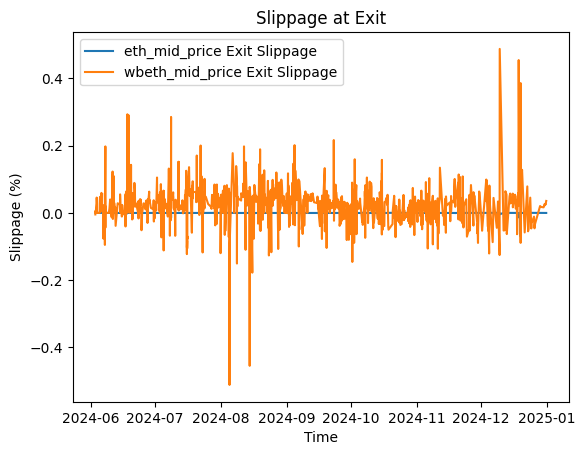

In [ ]:
plt.plot(S1_exit_slippage_percentage, label= f'{sym1} Exit Slippage')
plt.plot(S2_exit_slippage_percentage, label= f'{sym2} Exit Slippage')
plt.xlabel('Time')
plt.ylabel('Slippage (%)')
plt.title('Slippage at Exit')
plt.legend(loc='upper left')
plt.show()

In [42]:
#Print average S1 price change percent rounded to 2 decimal places

#Average Absolute Percentage Reversion
#---------------------------------------


In [43]:

def calculate_avg_abs_pct_reversion(trade_entries, trade_exits):
    """
    Calculate the average absolute percentage reversion from trade entry to trade exit
    for both asset price series (S1 and S2), using the interpolated trade data.
    
    Args:
        trade_entries (list): List of dictionaries for trade entries.
            Each dict should have keys: 'time', 'S1', 'S2', 'z', 'position'
        trade_exits (list): List of dictionaries for trade exits.
            Each dict should have keys: 'time', 'S1', 'S2', 'z', 'exit_type'
    
    Returns:
        overall_avg (float): The average of the average absolute percentage changes for S1 and S2.
    """
    S1_pct_changes = []
    S2_pct_changes = []
    
    # Loop over paired trade entries and exits.
    for entry, exit in zip(trade_entries, trade_exits):
        entry_S1 = entry['S1']
        entry_S2 = entry['S2']
        exit_S1 = exit['S1']
        exit_S2 = exit['S2']
        
        # Calculate absolute percentage change for each asset.
        pct_change_S1 = np.abs((exit_S1 - entry_S1) / entry_S1 * 100)
        pct_change_S2 = np.abs((exit_S2 - entry_S2) / entry_S2 * 100)
        
        S1_pct_changes.append(pct_change_S1)
        S2_pct_changes.append(pct_change_S2)
    
    # Compute the average absolute percentage change for S1 and S2.
    avg_abs_S1 = np.mean(S1_pct_changes) if S1_pct_changes else 0
    avg_abs_S2 = np.mean(S2_pct_changes) if S2_pct_changes else 0
    
    # Overall average is the average of the two.
    overall_avg = (avg_abs_S1 + avg_abs_S2) / 2
    
    print(f"Average absolute S1 price change percent: {avg_abs_S1:.2f}%")
    print(f"Average absolute S2 price change percent: {avg_abs_S2:.2f}%")
    print(f"Average of average absolute price changes: {overall_avg:.2f}%")
    
    return overall_avg



In [44]:
overall_avg_reversion = calculate_avg_abs_pct_reversion(trade_entries, trade_exits)

Average absolute S1 price change percent: 0.21%
Average absolute S2 price change percent: 0.22%
Average of average absolute price changes: 0.21%
